# Virtual Data Set Starter Notebook

#### *Author: Dean Henze, PO.DAAC*

Demonstrates basic functionality of virtual data sets (VDS's). Meant to serve as a modifiable template to explore data sets via this technology.

Keep in mind
* For out-of-cloud use, you may run into access errors if trying to do computations with more than ~20 years of data due to limitations on the number of simultaneous data requests that can be made at once. For complex or large computations with VDS's, please be in the cloud in the same location as the data (for PO.DAAC this is `us-west-2`).

## Environment

Minimal working installation for Python 3.13.3 environment is

```
fsspec==2024.10.0
earthaccess==0.11.0
virtualizarr==1.2.0
xarray==2025.1.2
zarr==2.18.4
kerchunk==0.2.7
dask==2024.5.2
h5netcdf==1.3.0
matplotlib==3.9.2
jupyterlab==4.4.2
```

In [1]:
# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr

# Other
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Obtaining credentials and generating a VDS mapper

Similarly to any access method for NASA Earthdata, access via VDS's still requires Earthdata Login credentials. Fortunately earthaccess makes this a one-liner. ***Rerun this line each hour to renew your credentials. If you are doing computations in later sections and suddenly hit access errors, you likely need to rerun this line.***

In [2]:
earthaccess.login()

The remaining task of defining some access keywords and mapper to the VDS is generic and can be wrapped into a function (no modification needed). The mapper will contain all the required access credentials and can be passed directly to xarray. In the future this step will likely be built into to earthaccess but for now we must define it in the notebook. The only inputs to the function are:

1. The link to the VDS reference file.
2. Whether or not you are accessing the data in the cloud in the same region as the data. For most beginning users this argument will be set to **False**.

In [3]:
def get_vds_mapper(vds_link, in_cloud_region=False):
    """
    Produces a virtudal dataset mapper that can be passed to xarray. 
    
    * vds_link: str, link to the mapper
    * in_cloud_region: bool, True if in cloud in the same region as the data, 
        False otherwise.
    """

    if in_cloud_region:
        fs_data = earthaccess.get_s3_filesystem(daac="PODAAC")
        remote_protocol = "s3"
    else:
        fs_data = earthaccess.get_fsspec_https_session()
        remote_protocol = "https"
    
    storage_opts = {"fo": vds_link, "remote_protocol": remote_protocol, "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    return fs_ref.get_mapper('')

## 2. Load data, explore, and do computations

The protocol to open the data will be identical for each collection. This section demonstrates the procedure for three data sets, then does some basic computations. 

The key action item is locating the VDS file link. In the future there will pathways to discover this information via data set landing pages and CMR metadata searches, but for now, please consult the table of VDS reference file links. If you are out of cloud, make sure the VDS link is for https endpoints and not s3 endpoints.

Loading the data is a one-liner using Xarray. At this point, the ability to utilize the data is limited only by the user's knowledge of the Xarray package, or subsetting and loading a portion of the data into your package of choice.

## 2.1 OSTIA-UKMO-L4-GLOB-REP-v2.0

Level 4 sea surface temperature data set, one timestamp per file.

#### Load data

In [4]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [5]:
%%time

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 492 ms, sys: 56.9 ms, total: 549 ms
Wall time: 602 ms


<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

#### Plot global sea surface temperature for first timestep

CPU times: user 2.88 s, sys: 268 ms, total: 3.15 s
Wall time: 5.85 s


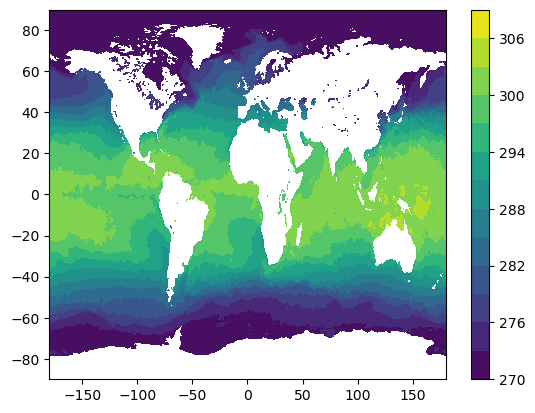

In [6]:
%%time

sst_t0 = data["analysed_sst"].isel(time=0)
plt.figure()
plt.contourf(sst_t0["lon"], sst_t0["lat"], sst_t0.values, levels=np.arange(270, 310, 3))
plt.colorbar()

#### Time series of regional mean sea surface temperature

Subset to 10 x 10 degree window off the USA northwest coast, compute mean over this window for each timestep. Currently the time bounds are set for the first decade of data.

In [7]:
time_bounds = ("1982-01-02T00:00:00", "1992-01-02T00:00:00")
lon_bounds = (-135,-125)  # for -180 to 180 domain
lat_bounds = (35, 45)

In [8]:
data_subset = data.sel(time=slice(*time_bounds)).sel(lon=slice(*lon_bounds), lat=slice(*lat_bounds))
data_subset

<xarray.Dataset> Size: 4GB
Dimensions:           (time: 3652, lat: 200, lon: 200)
Coordinates:
  * lat               (lat) float32 800B 35.03 35.08 35.12 ... 44.88 44.92 44.97
  * lon               (lon) float32 800B -135.0 -134.9 -134.9 ... -125.1 -125.0
  * time              (time) datetime64[ns] 29kB 1982-01-02T12:00:00 ... 1992...
Data variables:
    analysed_sst      (time, lat, lon) float64 1GB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 1GB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    mask              (time, lat, lon) float32 584MB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 1GB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [9]:
%%time

region_mean_ts = data_subset["analysed_sst"].mean(dim=("lon","lat")).compute()

CPU times: user 1min 32s, sys: 28.5 s, total: 2min
Wall time: 5min 15s


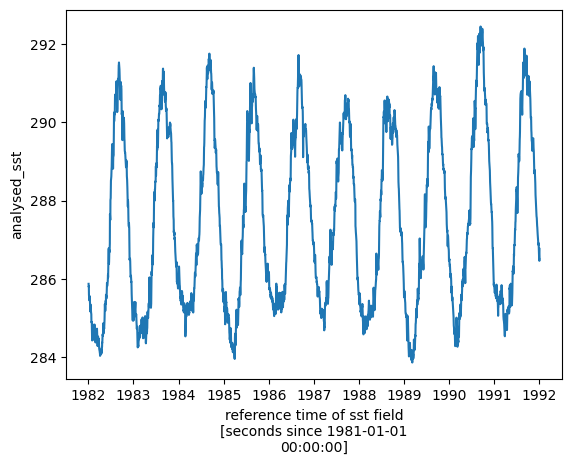

In [10]:
fig = plt.figure(figsize=(8,4), layout="tight")
ax = plt.axes()
plt.plot(region_mean_ts["time"].values, region_mean_ts.values)
plt.xlabel("Year", fontsize=20)
plt.ylabel("SST (K)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

## 2.2 CCMP_WINDS_10M6HR_L4_V3.1

Level 4 dataset with 4 timestamps per file (6-hourly) and longitude range 0-360. The code in this section is mostly identical to the previous section.

#### Load data

In [40]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_WINDS_10M6HR_L4_V3.1_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [41]:
%%time

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 54.6 ms, sys: 5.45 ms, total: 60.1 ms
Wall time: 61.8 ms


<xarray.Dataset> Size: 781GB
Dimensions:    (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

#### Plot global ocean surface wind for first timestep

CPU times: user 252 ms, sys: 59.5 ms, total: 311 ms
Wall time: 2.12 s


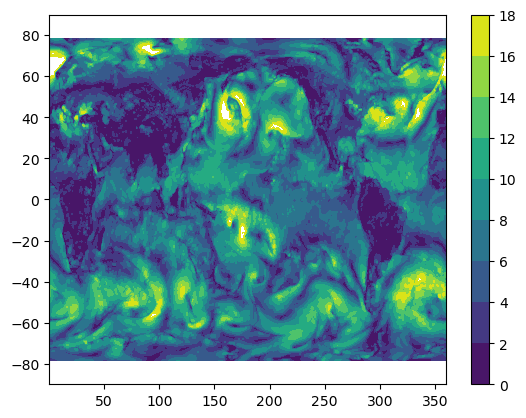

In [42]:
%%time

ws_t0 = data["ws"].isel(time=0)
plt.figure()
plt.contourf(ws_t0["longitude"], ws_t0["latitude"], ws_t0.values, levels=np.arange(0, 20, 2))
plt.colorbar()

#### Time series of regional mean wind speed

Subset to 10 x 10 degree window off the USA northwest coast, compute mean over this window for each day. For the CCMP data set which is 6-hourly, this includes resampling to once daily data. Currently the time bounds are set for the first decade of data.

In [46]:
time_bounds = ("1993-01-02T00:00:00", "2003-01-02T00:00:00")
lon_bounds = (225,235)  # for 0 to 360 domain
lat_bounds = (35, 45)

In [47]:
# First subset by time then by space.
# For temporal subset, also resample the 6-hourly frequency to once daily:
data_subset = data.sel(time=slice(*time_bounds)).resample(time="1d").nearest()
data_subset = data_subset.sel(longitude=slice(*lon_bounds), latitude=slice(*lat_bounds))
data_subset

<xarray.Dataset> Size: 9MB
Dimensions:    (latitude: 40, longitude: 40, time: 366)
Coordinates:
  * latitude   (latitude) float32 160B 35.12 35.38 35.62 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 160B 225.1 225.4 225.6 ... 234.4 234.6 234.9
  * time       (time) datetime64[ns] 3kB 1993-01-02 1993-01-03 ... 1994-01-02
Data variables:
    nobs       (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

In [25]:
%%time

region_mean_ts = data_subset["ws"].mean(dim=("longitude","latitude")).compute()

CPU times: user 1min 49s, sys: 45.6 s, total: 2min 34s
Wall time: 8min 36s


In [50]:
# The wind speed seasonal cycle is noisier than e.g. SST, so also compute a 
# monthly rolling mean to plot:
rolling_mean_ts = region_mean_ts.rolling(time=30).mean()

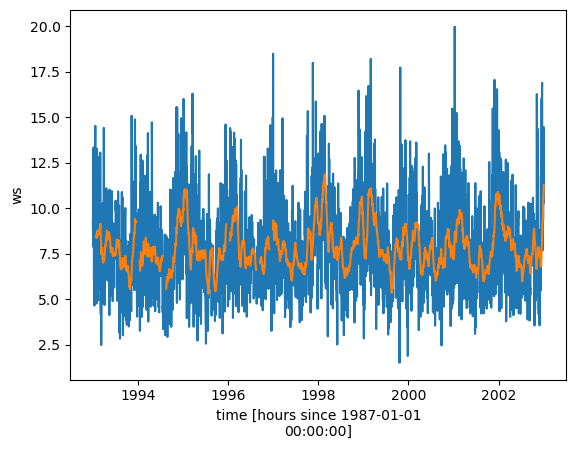

In [27]:
fig = plt.figure(figsize=(8,4), layout="tight")
ax = plt.axes()
plt.plot(region_mean_ts["time"].values, region_mean_ts.values)
plt.plot(rolling_mean_ts["time"].values, rolling_mean_ts.values)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Wind Speed (m s-1)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

## 2.3 ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4

Level 4 model output for ocean temperature and salinity with one timestamp per file and dimensions (time, latitude, longitude, depth). The code in this section is mostly identical to the previous section.

#### Load data

In [75]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [76]:
%%time

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 295 ms, sys: 37.6 ms, total: 333 ms
Wall time: 4.33 s


<xarray.Dataset> Size: 985GB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
Attributes: (12/53)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides daily-averaged oce...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           ECCO Ocean Temperature and Salinity - Da...

#### Plot global ocean salinity at 5m depth for first timestep

CPU times: user 296 ms, sys: 45.4 ms, total: 341 ms
Wall time: 1.64 s


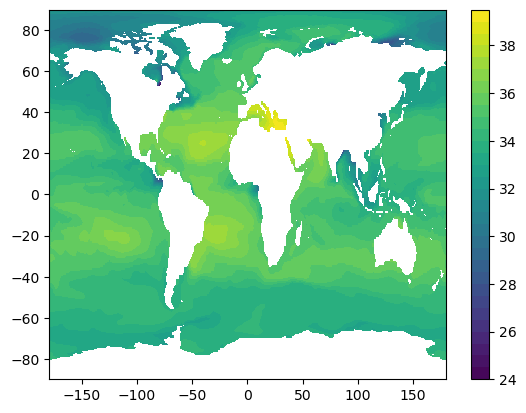

In [67]:
%%time

salt_t0 = data["SALT"].isel(time=0, Z=0)
plt.figure()
plt.contourf(salt_t0["longitude"], salt_t0["latitude"], salt_t0.values, levels=np.arange(24, 40, 0.5))
plt.colorbar()

#### Time series of regional mean ocean salinity at 5m depth

Subset to 10 x 10 degree window off the USA northwest coast, compute mean over this window for each day. Currently the time bounds are set for the first decade of data.

In [72]:
time_bounds = ("1992-01-02T00:00:00", "2002-01-02T00:00:00")
lon_bounds = (-135,-125)  # for -180 to 180 domain
lat_bounds = (35, 45)

In [73]:
# First subset by time then by space (horizontal and vertical):
data_subset = data.sel(time=slice(*time_bounds))
data_subset = data_subset.sel(longitude=slice(*lon_bounds), latitude=slice(*lat_bounds))
data_subset = data_subset.isel(Z=0)
data_subset

<xarray.Dataset> Size: 1MB
Dimensions:         (time: 366, latitude: 20, longitude: 20, nv: 2)
Coordinates:
    Z               float32 4B -5.0
    Z_bnds          (nv) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
  * latitude        (latitude) float32 80B 35.25 35.75 36.25 ... 44.25 44.75
    latitude_bnds   (latitude, nv) float32 160B dask.array<chunksize=(20, 2), meta=np.ndarray>
  * longitude       (longitude) float32 80B -134.8 -134.2 ... -125.8 -125.2
    longitude_bnds  (longitude, nv) float32 160B dask.array<chunksize=(20, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 3kB 1992-01-02T12:00:00 ... 1993-01...
    time_bnds       (time, nv) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, latitude, longitude) float32 586kB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    THETA           (time, latitude, longitude) float32 586kB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
Attributes: (12/53)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides daily-averaged oce...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           ECCO Ocean Temperature and Salinity - Da...

In [32]:
%%time

region_mean_ts = data_subset["SALT"].mean(dim=("longitude","latitude")).compute()

CPU times: user 1min 46s, sys: 32.1 s, total: 2min 18s
Wall time: 6min 19s


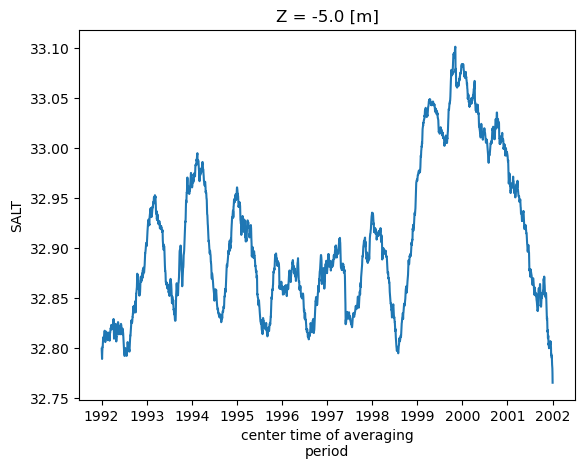

In [33]:
fig = plt.figure(figsize=(8,4), layout="tight")
ax = plt.axes()
plt.plot(region_mean_ts["time"].values, region_mean_ts.values)
plt.xlabel("Year", fontsize=20)
plt.ylabel("SALT (PSU)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

## 3. Downloading a subset of the data as a netCDF locally

**Only Section 1 needs to be run prior to this section. Section 2 can be skipped.**

In [4]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [22]:
%%time

data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 27.8 ms, sys: 3.73 ms, total: 31.5 ms
Wall time: 31 ms


<xarray.Dataset> Size: 10TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) int8 398GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    coordinates:                time lat lon

In [10]:
time_bounds = ("1992-01-02T00:00:00", "1993-01-02T00:00:00")
lon_bounds = (-135,-115)  # for -180 to 180 domain
lat_bounds = (25, 45)

In [11]:
data_subset = data.sel(time=slice(*time_bounds)).sel(lon=slice(*lon_bounds), lat=slice(*lat_bounds))
sst_for_downloading = data_subset["analysed_sst"]
sst_for_downloading

<xarray.DataArray 'analysed_sst' (time: 60, lat: 400, lon: 400)> Size: 77MB
dask.array<getitem, shape=(60, 400, 400), dtype=float64, chunksize=(1, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 25.02 25.08 25.12 25.17 ... 44.88 44.92 44.97
  * lon      (lon) float32 2kB -135.0 -134.9 -134.9 ... -115.1 -115.1 -115.0
  * time     (time) datetime64[ns] 480B 1992-01-02T12:00:00 ... 1992-03-01T12...
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    comment:         OSTIA foundation SST

In [12]:
def fix_attrs(attrs, extra_time_fix=False):
    
    # First convert any booleans to strings:
    for atr, value in attrs.items():
        if type(value) == bool:
            attrs[atr] = str(value)
    
    # Then fix the 'preferred_chunks' field (should not be dict):
    if 'preferred_chunks' in attrs:
        pref_chunks = attrs['preferred_chunks']
        if type(pref_chunks) == dict:
            pref_chunks_list = [e[1] for e in pref_chunks.items()]
            attrs['preferred_chunks'] = pref_chunks_list

    if extra_time_fix:
        # Remove problematic attributes for time encoding,
        # (Likely due to time already being decoded in VDS?)
        if 'units' in attrs:
            del attrs['units']
        if '_FillValue' in attrs:
            del attrs['_FillValue']

    return attrs

In [13]:
for coord in sst_for_downloading.coords:
    if coord == "time":
        sst_for_downloading[coord].attrs = fix_attrs(sst_for_downloading[coord].attrs, extra_time_fix=True)
    else:
        sst_for_downloading[coord].attrs = fix_attrs(sst_for_downloading[coord].attrs, extra_time_fix=False)

In [14]:
%%time

sst_for_downloading.to_netcdf("sst_subset.nc")

CPU times: user 3.43 s, sys: 906 ms, total: 4.34 s
Wall time: 11.5 s


In [15]:
sst_reloaded = xr.open_dataset("sst_subset.nc")
sst_reloaded

<xarray.Dataset> Size: 77MB
Dimensions:       (lat: 400, lon: 400, time: 60)
Coordinates:
  * lat           (lat) float32 2kB 25.02 25.08 25.12 ... 44.88 44.92 44.97
  * lon           (lon) float32 2kB -135.0 -134.9 -134.9 ... -115.1 -115.0
  * time          (time) datetime64[ns] 480B 1992-01-02T12:00:00 ... 1992-03-...
Data variables:
    analysed_sst  (time, lat, lon) float64 77MB ...

In [21]:
sst_reloaded["analysed_sst"].min().values

array(-54.5300061)

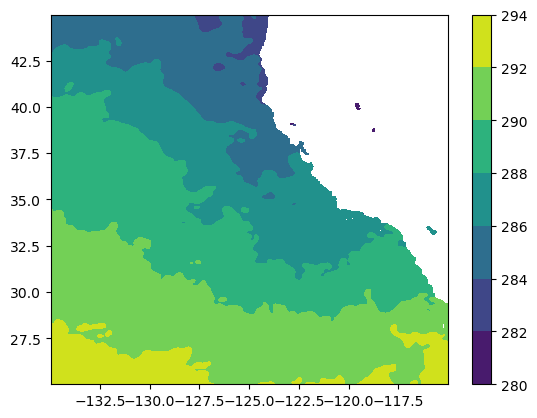

In [19]:
sst_t0 = sst_reloaded["analysed_sst"].isel(time=0)
plt.figure()
plt.contourf(sst_t0["lon"], sst_t0["lat"], sst_t0.values, levels=np.arange(280, 296, 2))
plt.colorbar()

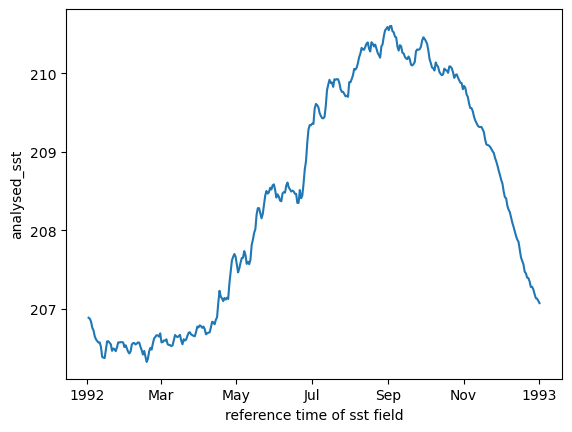

In [50]:
sst_reloaded["analysed_sst"].mean(dim=["lon", "lat"]).plot()

In [34]:
sst_reloaded.close()